<h1 align=center><font size = 5><b>Où ouvrir mon restaurant de Poké ?</b></font></h1>

*Ce projet est un projet personnel, pour plus d’information veuillez consulter <a href="https://github.com/Ashish-3/Ouvrir-mon-poke/blob/master/README.md/">ce lien vers le fichier readme</a>.
Pour une compréhension du code par un public varié, les annotations on été faites en anglais.*


### Importing the librairies

In [3]:
import pandas as pd
import numpy as np
import geocoder
import folium
from folium import plugins
import requests # library to handle requests
import math
import re

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# For loading Foursquares credentials
import os
import requests
from dotenv import load_dotenv
load_dotenv()

True

### Fetching a list of most populated citiesand their position in France

In [4]:
df=pd.read_html("https://fr.wikipedia.org/wiki/Liste_des_communes_de_France_les_plus_peupl%C3%A9es#cite_note-pop2020-5")[0]
print(df.shape)
df.head()

(275, 14)


Rang2020 CodeInsee    Commune            Département      Statut  \
  Rang2020 CodeInsee    Commune            Département      Statut   
0        1     75056      Paris                  Paris  Préfecture   
1        2     13055  Marseille       Bouches-du-Rhône  Préfecture   
2        3     69123       Lyon  Métropole de Lyon[12]  Préfecture   
3        4     31555   Toulouse          Haute-Garonne  Préfecture   
4        5     06088       Nice        Alpes-Maritimes  Préfecture   

                       Région Population légale                        \
                       Région           2017[5]    2012[6]    2007[7]   
0               Île-de-France         2 187 526  2 240 621  2 193 030   
1  Provence-Alpes-Côte d'Azur           863 310    852 516    852 395   
2        Auvergne-Rhône-Alpes           516 092    496 343    472 330   
3                   Occitanie           479 553    453 317    439 453   
4  Provence-Alpes-Côte d'Azur           340 017    343 629    348 721   

                                                               
  1999[8],[9]    1990[8]    1982[8] 1975[8],[10] 1968[8],[11]  
0   2 125 246  2 152 423  2 176 243    2 299 830    2 590 771  
1     798 430    800 550    874 436      908 600      889 029  
2     445 452    415 487    413 095      456 716      527 800  
3     390 350    358 688    347 995      373 796      370 796  
4     342 738    342 439    337 085      344 481      322 442

In [5]:
# Creating a dataframe contaning a list of the cities and their populationulation as strings
cities=pd.DataFrame()
cities['city']=pd.Series(map(str, df[('Commune','Commune')]))
cities['population']=pd.Series(map(str, df[('Population légale',      '2017[5]')]))

# Cleaning the unwanted special characters to set the populationulation column as int
cities['population'].replace(r"\s+",'', regex=True, inplace=True)
cities.replace("[\(\[].*?[\)\]]", "",regex=True, inplace=True)
cities['population']=cities['population'].astype(int)

#Get only the 10 biggest cities in France
cities.sort_values(by=['population'] , ascending=False).head(20)
cities=cities.head(15)
cities

,city,population
0,Paris,2187526
1,Marseille,863310
2,Lyon,516092
3,Toulouse,479553
4,Nice,340017
5,Nantes,309346
6,Montpellier,285121
7,Strasbourg,280966
8,Bordeaux,254436
9,Lille,232787


In [6]:
# Get the coordinates of the cities
latitudes=[]
longitudes=[]

for city in cities['city'] :
    lat_lng_coords = []
    # loop until you get the coordinates
    while( len(lat_lng_coords)==0):
        g = geocoder.arcgis('{}, France'.format(city))
        lat_lng_coords = g.latlng
    latitudes.append(lat_lng_coords[0])
    longitudes.append(lat_lng_coords[1])

# Append the coordinates in the cities dataframe    
cities['city_lat']=latitudes
cities['city_lng']=longitudes

In [7]:
# Save the dataframe localy to avoid requesting the arcgis API through Geocoder everytime 
cities.to_csv('cities.csv', index=False)

In [30]:
# Load the saved cities dataframe if we reopen the jupyter notebook 
cities=pd.read_csv('cities.csv', nrows=5)

In [8]:
cities

,city,population,city_lat,city_lng
0,Paris,2187526,48.85717,2.34140
1,Marseille,863310,43.29337,5.37132
2,Lyon,516092,45.75919,4.82966
3,Toulouse,479553,43.60579,1.44863
4,Nice,340017,43.70025,7.27774
5,Nantes,309346,47.21811,-1.55306
6,Montpellier,285121,43.61086,3.87612
7,Strasbourg,280966,48.58504,7.73642
8,Bordeaux,254436,44.83670,-0.58107
9,Lille,232787,50.62820,3.06881


###  Searching for the venues in the cities with Foursquare's API

In [9]:
# Initializing credentials
CLIENT_ID = os.getenv('FOURSQUARE_ID') # Foursquare ID
CLIENT_SECRET = os.getenv('FOURSQUARE_SECRET') # Foursquare Secret
VERSION = '20200901' # Foursquare API version

# Initializing parameters
LIMIT = 200
radius=10000   
query=['poke']

In [10]:
venuesList=[]
for city, lat, lng in zip(cities['city'], cities['city_lat'], cities['city_lng']):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT,
        query)

    # make the GET request
    results = requests.get(url).json()
    
    # Notify if any empty request and add an empty row for them
    if len(results['response']['venues'])==0 :
        print('Nothing found for', city, 'at', lat, lng, ' Replaced with empty row' )
        venuesList.append([city,lat,lng,np.nan,np.nan,np.nan,np.nan,np.nan])
    # Get the information we need from the json file into a list
    else :
        for i in range(0,len(results['response']['venues'])) :
            venuesList.append([city,
                         lat,
                         lng,
                         results['response']['venues'][i]['id'], 
                         results['response']['venues'][i]['name'],
                         results['response']['venues'][i]['location']['lat'],
                         results['response']['venues'][i]['location']['lng'],
                         results['response']['venues'][i]['categories']
                         ])

# Converting our lists of venues into a dataframe
venues = None
venues = pd.DataFrame([item for item in venuesList])
venues.columns=['city','city_lat','city_lng','venue_id', 'venue_name', 'venue_lat','venue_lng','venue_cat']

# Get the category of a venue while handling the exeptions because:
    # - Some venues' categories are NaN therefor not a list --> no action needed
    # - Some venues' categories are an empty list --> change into NaN
    # - Some venues' categories a list with a json hierarchy --> get the actual category name
for i in range(0,len(venues['venue_cat'])):
    if isinstance(venues['venue_cat'][i] , list) :
        if len(venues['venue_cat'][i])==0 :
            try : venues.loc[i,'venue_cat']=np.nan
            except :  None
        else :
             try : venues.loc[i,'venue_cat']=venues['venue_cat'][i][0]['name']
             except :  None
venues.head()

Nothing found for Marseille at 43.29337000000004 5.371320000000026  Replaced with empty row
Nothing found for Lille at 50.62820000000005 3.068810000000042  Replaced with empty row
Nothing found for Rennes at 48.108040000000074 -1.6844899999999257  Replaced with empty row
Nothing found for Saint-Étienne at 45.43988000000007 4.395530000000065  Replaced with empty row
Nothing found for Toulon at 43.116670000000056 5.933330000000069  Replaced with empty row
Nothing found for Le Havre at 49.49359000000004 0.10097000000007483  Replaced with empty row


,city,city_lat,city_lng,venue_id,venue_name,venue_lat,venue_lng,venue_cat
0,Paris,48.85717,2.3414,5b30cada4f0e58002c763b7c,Palika Poke,48.868004,2.346554,Fast Food Restaurant
1,Paris,48.85717,2.3414,5d5d2869a7447f000857e2a0,Dice Poké,48.867726,2.332474,Poke Place
2,Paris,48.85717,2.3414,5bfeddad1c0b34002cfebd30,ïnuï - Poke Bowl à Paris,48.874485,2.320749,Restaurant
3,Paris,48.85717,2.3414,5a7ef924a35dce7e3c4b1145,SHAKA Poke,48.861969,2.341580,Restaurant
4,Paris,48.85717,2.3414,5b27911186f4cc00380f8e54,Hawaiian Poké,48.869530,2.342972,Poke Place


In [11]:
venues.shape

(83, 8)

In [12]:
# Save the dataframe localy to avoid requesting Foursquare everytime 
venues.to_csv('venues.csv', index=False)

In [36]:
# Load the saved venues dataframe if we reopen the jupyter notebook 
venues=pd.read_csv('venues.csv')

In [13]:
venues.head()

,city,city_lat,city_lng,venue_id,venue_name,venue_lat,venue_lng,venue_cat
0,Paris,48.85717,2.3414,5b30cada4f0e58002c763b7c,Palika Poke,48.868004,2.346554,Fast Food Restaurant
1,Paris,48.85717,2.3414,5d5d2869a7447f000857e2a0,Dice Poké,48.867726,2.332474,Poke Place
2,Paris,48.85717,2.3414,5bfeddad1c0b34002cfebd30,ïnuï - Poke Bowl à Paris,48.874485,2.320749,Restaurant
3,Paris,48.85717,2.3414,5a7ef924a35dce7e3c4b1145,SHAKA Poke,48.861969,2.341580,Restaurant
4,Paris,48.85717,2.3414,5b27911186f4cc00380f8e54,Hawaiian Poké,48.869530,2.342972,Poke Place


### Preprocessing the result

##### Some of the venues returned by Foursquare aren't actually restaurants, let's remove them

In [14]:
# Let's define a black list
# The query "poke" is confused with "poker", "pokemon" or other words
# It often return non restaurant places like "flea market" or "garden"

black_list=['poker', 'pokemon', 'market', 'garden']

In [15]:
# initializing some variables
dropped=[]
index_to_drop=set() #I'm using a set instead of a list so there are no indices that are present twice
city_present=set(venues['city'])

# Getting the index of the rows to dropped
for word in black_list :
    for i in range(0,venues.shape[0]):
        if isinstance(venues['venue_name'][i] , str) :
            if word in venues['venue_name'][i].lower():
                dropped.append(dict(venues.iloc[i]))
                index_to_drop.add(i)
        if isinstance(venues['venue_cat'][i] , str) :
            if word in venues['venue_cat'][i].lower():
                dropped.append(dict(venues.iloc[i]))
                index_to_drop.add(i)

# Print the index of rows to be drop and drop them                
print('The index dropped are :', index_to_drop)
venues.drop(list(index_to_drop), inplace=True)            

# If a venue dropped was the last one of it's city, add an empty row to represent the city
for city, lat, lng in zip(city_present, cities.city_lat, cities.city_lng) :
    if not (city in str(venues['city'])) :
        print('Last venue of ', city, ' dropped. Replaced with empty row for this city' )
        venues=venues.append(cities[['city', 'city_lat', 'city_lng']][cities['city']==city])

# Reset the indexes to prevent any errors
venues.reset_index(inplace=True, drop=True)

# Show a dataframe of the dropped venues
print('The venues dropped are :')
dropped=pd.DataFrame(dropped)
dropped
    

The index dropped are : {34, 38, 42, 45, 46, 47, 48, 49, 52, 53, 55, 56, 60, 61, 63, 65, 67, 74, 75, 76, 79}
Last venue of  Nantes  dropped. Replaced with empty row for this city
Last venue of  Reims  dropped. Replaced with empty row for this city
The venues dropped are :


,city,city_lat,city_lng,venue_id,venue_name,venue_lat,venue_lng,venue_cat
0,Paris,48.85717,2.34140,4ce3134d438b224bd46780a3,Club Poker Radio,48.853844,2.339958,Bar
1,Paris,48.85717,2.34140,50d0a497e4b0e3ff09cdf67a,Poker Academie,48.867444,2.357494,Coworking Space
2,Paris,48.85717,2.34140,4b726055f964a52036792de3,Pokerstars,48.882038,2.288852,NaN
3,Paris,48.85717,2.34140,517e35a0e4b0347e2cdc787a,EuroPoker,48.902601,2.329831,Tech Startup
4,Paris,48.85717,2.34140,4db5bdcf43a1369cb5d69d1f,Clichy Poker Tour,48.901598,2.314335,Gaming Cafe
5,Paris,48.85717,2.34140,508a8672e4b05789447eaa3b,RedCactus Poker Events,48.901075,2.301163,General Entertainment
6,Paris,48.85717,2.34140,4f3a81afe4b03d32dfc2f62f,LB Poker,48.830351,2.276020,Tech Startup
7,Paris,48.85717,2.34140,4b91782df964a520edbe33e3,La maison du Poker,48.828220,2.277404,Casino
8,Lyon,45.75919,4.82966,5234e3b411d20a281a8bc3ea,Poker Hard,45.771375,4.867000,Arcade
9,Lyon,45.75919,4.82966,4f30447ae4b01982f3ecbfe0,Bibelot Poker Tour New Place,45.757418,4.866342,Gay Bar


In [40]:
# Unquote the cell to manualy review the venues if needed
venues

,city,city_lat,city_lng,venue_id,venue_name,venue_lat,venue_lng,venue_cat
0,Paris,48.85717,2.34140,5b30cada4f0e58002c763b7c,Palika Poke,48.868004,2.346554,Fast Food Restaurant
1,Paris,48.85717,2.34140,5d5d2869a7447f000857e2a0,Dice Poké,48.867726,2.332474,Poke Place
2,Paris,48.85717,2.34140,5bfeddad1c0b34002cfebd30,ïnuï - Poke Bowl à Paris,48.874485,2.320749,Restaurant
3,Paris,48.85717,2.34140,5a7ef924a35dce7e3c4b1145,SHAKA Poke,48.861969,2.341580,Restaurant
4,Paris,48.85717,2.34140,5cfc038c9e0d54002c0b7011,Poké Fresh,48.847173,2.343081,Hawaiian Restaurant
5,Paris,48.85717,2.34140,5ec6b7f87eff4f0008a29040,Fancy Poke Roll,48.866154,2.347773,Poke Place
6,Paris,48.85717,2.34140,5f294c8b97900e25c1db8530,Palika Poke,48.843781,2.352592,Poke Place
7,Paris,48.85717,2.34140,5b27911186f4cc00380f8e54,Hawaiian Poké,48.869530,2.342972,Poke Place
8,Paris,48.85717,2.34140,58fa080b603d2a4855ca9268,Poké Bar Hawaii-Paris,48.869895,2.335474,Poke Place
9,Paris,48.85717,2.34140,5832a9b63f5a5c17ff115061,Ono Poké,48.845847,2.342944,Poke Place


### Let's display the venues and the search radius on the map of France

In [16]:
#g = geocoder.arcgis('France')

# create map of France using latitude and longitude values
map_france = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=6)

# instantiate a mark cluster object for the venues in the dataframe
venues_cluster = plugins.MarkerCluster().add_to(map_france)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(venues.venue_lat, venues.venue_lng, venues.venue_name):
    if isinstance(label , str) :
        folium.Marker(
            location=[lat, lng],
            icon=None,
            popup=label,
        ).add_to(venues_cluster)

# instantiate a feature group for the cities in the dataframe
cities_range = folium.map.FeatureGroup()

# loop through the cities and add each to the incidents feature group
for lat, lng, in zip(cities.city_lat, cities.city_lng):
    cities_range.add_child(
        folium.Circle(
            [lat, lng],
            radius=radius, # define how big you want the circle markers to be
            color='orange',
            fill=True,
            fill_color='orange',
            fill_opacity=0.3
        )
    )        
        
# add incidents to map
map_france.add_child(cities_range)
        
map_france

### Let's do a quick analysis of the occurences per city

In [17]:
# Count the occurence of the venue per city
summary=venues[['city', 'venue_name']].groupby('city').count()
summary.rename(columns={'venue_name':'venue_count'}, inplace=True)

# Complete the dataframe with the population per city and calculate the occurence per million person
summary= pd.merge(summary, cities[['city','population']], on=['city'])
summary["venue_per_million"]=round((summary.venue_count/summary.population)*pow(10,6),1)

# Sort the dataframe by population and by occurence per million capita
summary.sort_values(by=['population'] , ascending=True, inplace=True)
summary.sort_values(by=['venue_per_million'] , ascending=True, inplace=True)

#Reorder the columns
cols = summary.columns.tolist()
cols=cols[:1] + cols[-1:] + cols[1:3] 
summary = summary[cols]

#Display the summary dataframe
summary

,city,venue_per_million,venue_count,population
1,Le Havre,0.0,0,170147
13,Toulon,0.0,0,171953
11,Saint-Étienne,0.0,0,172565
9,Reims,0.0,0,182460
10,Rennes,0.0,0,216815
2,Lille,0.0,0,232787
6,Nantes,0.0,0,309346
4,Marseille,0.0,0,863310
7,Nice,2.9,1,340017
5,Montpellier,3.5,1,285121


### Let's plot the results

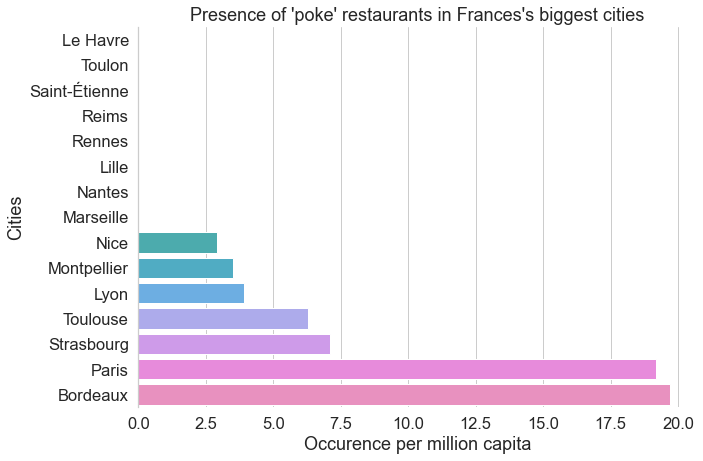

In [23]:
# define figure size
plt.figure(figsize=(10, 7))

# define background style and font size
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# generate plot and add title and axes labels
ax = sns.barplot(x='venue_per_million' , y='city', data=summary)
ax.set(xlabel='Occurence per million capita', ylabel='Cities')
ax.set_title("Presence of '{}' restaurants in Frances's biggest cities".format(query[0]))
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False)


plt.savefig('city_poke_compar.png')